In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import math

import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib.lines import Line2D

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams["font.family"] = "Times New Roman"

In [2]:
SOURCE_NAME_MAP = {
    'arxiv': 'ArXiv',
    #'wikipedia_(en)': 'Wikipedia',
    'hackernews': 'HackerNews',
    # 'github': 'Github'
}
sources = list(SOURCE_NAME_MAP.keys())
COLOR_MAP = {
    "Member": "C0",
    "Non-Member": "C1",
    "Modified Member": "C2",
}
ATTACK_NAME_MAP = {
    'loss': 'LOSS',
    'ref-stablelm-base-alpha-3b-v2': 'Ref'
}

In [3]:
attacks_focus = {
    'loss': 'likelihood_threshold',
    'ref-stablelm-base-alpha-3b-v2': 'ref-stablelm-base-alpha-3b-v2'
}


In [4]:
def get_source_data(src: str, atk: str, specific_fpr: float = None):
    # filename = f"./mia_unified_mia_v5_sanitycheck_natural_wiki_arxiv/EleutherAI_pythia-12b-deduped--bert-temp/fp32-0.3-1-the_pile-the_pile-1000200100_plen30_--tok_false-{src}_ngram_13_<0.8_truncated/{attack_focus}_results.json"
    if atk == 'ref-stablelm-base-alpha-3b-v2':
        filename = f"./results_for_niloofar/stable_lm_ref/EleutherAI_pythia-12b-deduped--bert-temp/fp32-0.3-1-the_pile-the_pile-1000200100_plen30_--tok_false-{src}_ngram_13_<0.8_truncated/{attacks_focus[atk]}_results.json"
    else:
        filename = f"./results_for_niloofar/gen_exp/EleutherAI_pythia-12b-deduped--bert-temp/fp32-0.3-1-the_pile-the_pile-1000200100_plen30_--tok_false-{src}_ngram_13_<0.8_truncated/{attacks_focus[atk]}_results.json"

    with open(filename, 'r') as f:
        og_data = json.load(f)['predictions']
    
    try:
        member_scores = og_data['members']
        nonmember_scores = og_data['nonmembers']
    except:
        member_scores = og_data['member']
        nonmember_scores = og_data['nonmember']
    
    preds_member_ = -np.array(member_scores)
    preds_nonmember_ = -np.array(nonmember_scores)
    total_preds = np.concatenate((preds_member_ , preds_nonmember_))
    
    total_labels = [1] * len(preds_member_) + [0] * len(preds_nonmember_)
    fpr, tpr, thresholds = roc_curve(total_labels, total_preds)
    if specific_fpr is not None:
        thr_index = np.where(np.array(fpr) < specific_fpr)[0][-1]
        return_extra = thresholds[thr_index]
    else:
        return_extra = auc(fpr, tpr)
    return preds_member_, preds_nonmember_, return_extra

In [5]:
def get_edited_member_scores(src: str, atk: str):
    with open(f"./newmia_results_all/{src}.json", 'r') as f:
        d = json.load(f)
    care = d[atk]
    return care

In [6]:
def filter_out_nan(x):
    return [element for element in x if not math.isnan(element)]

In [7]:
def get_auc_from_thresholds(preds_member, preds_nonmember):
    """
    Compute FPRs and TPRs corresponding to given thresholds
    """
    tpr, fpr = [], []
    for threshold in thresholds:
        tp = np.sum(preds_member >= threshold)
        tn = np.sum(preds_nonmember < threshold)
        fp = np.sum(preds_nonmember >= threshold)
        fn = np.sum(preds_member < threshold)

        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    
    tpr = np.array(tpr)
    fpr = np.array(fpr)
    return auc(fpr, tpr)

In [156]:
preds_member_ = -np.array(member_scores)
preds_nonmember_ = -np.array(nonmember_scores)
total_preds = np.concatenate((preds_member_ , preds_nonmember_))

total_labels = [1] * len(preds_member_) + [0] * len(preds_nonmember_)
fpr, tpr, thresholds = roc_curve(total_labels, total_preds)
roc_auc = auc(fpr, tpr)

In [157]:
roc_auc

0.5592170000000001

In [158]:
get_auc_from_thresholds(preds_member_, preds_nonmember_)

0.5592170000000001

In [159]:
edited_members_scores = "/mmfs1/gscratch/h2lab/micdun/mimir/edit_distance_members/scores/wikipedia_(en).json"
with open(edited_members_scores, 'r') as f:
    d = json.load(f)

In [160]:
care = d[attack_focus]

## Consider edited-members as members

In [161]:
columns = ['edit distance', 'AUC']
raw_data = []
raw_data.append((0, roc_auc))

for n, v in care.items():
    for score in v.values():
        pm = -np.array(score)
        raw_data.append((int(n), get_auc_from_thresholds(pm, preds_nonmember_)))

In [162]:
df = pd.DataFrame(raw_data, columns=columns)

<Axes: xlabel='edit distance', ylabel='AUC'>

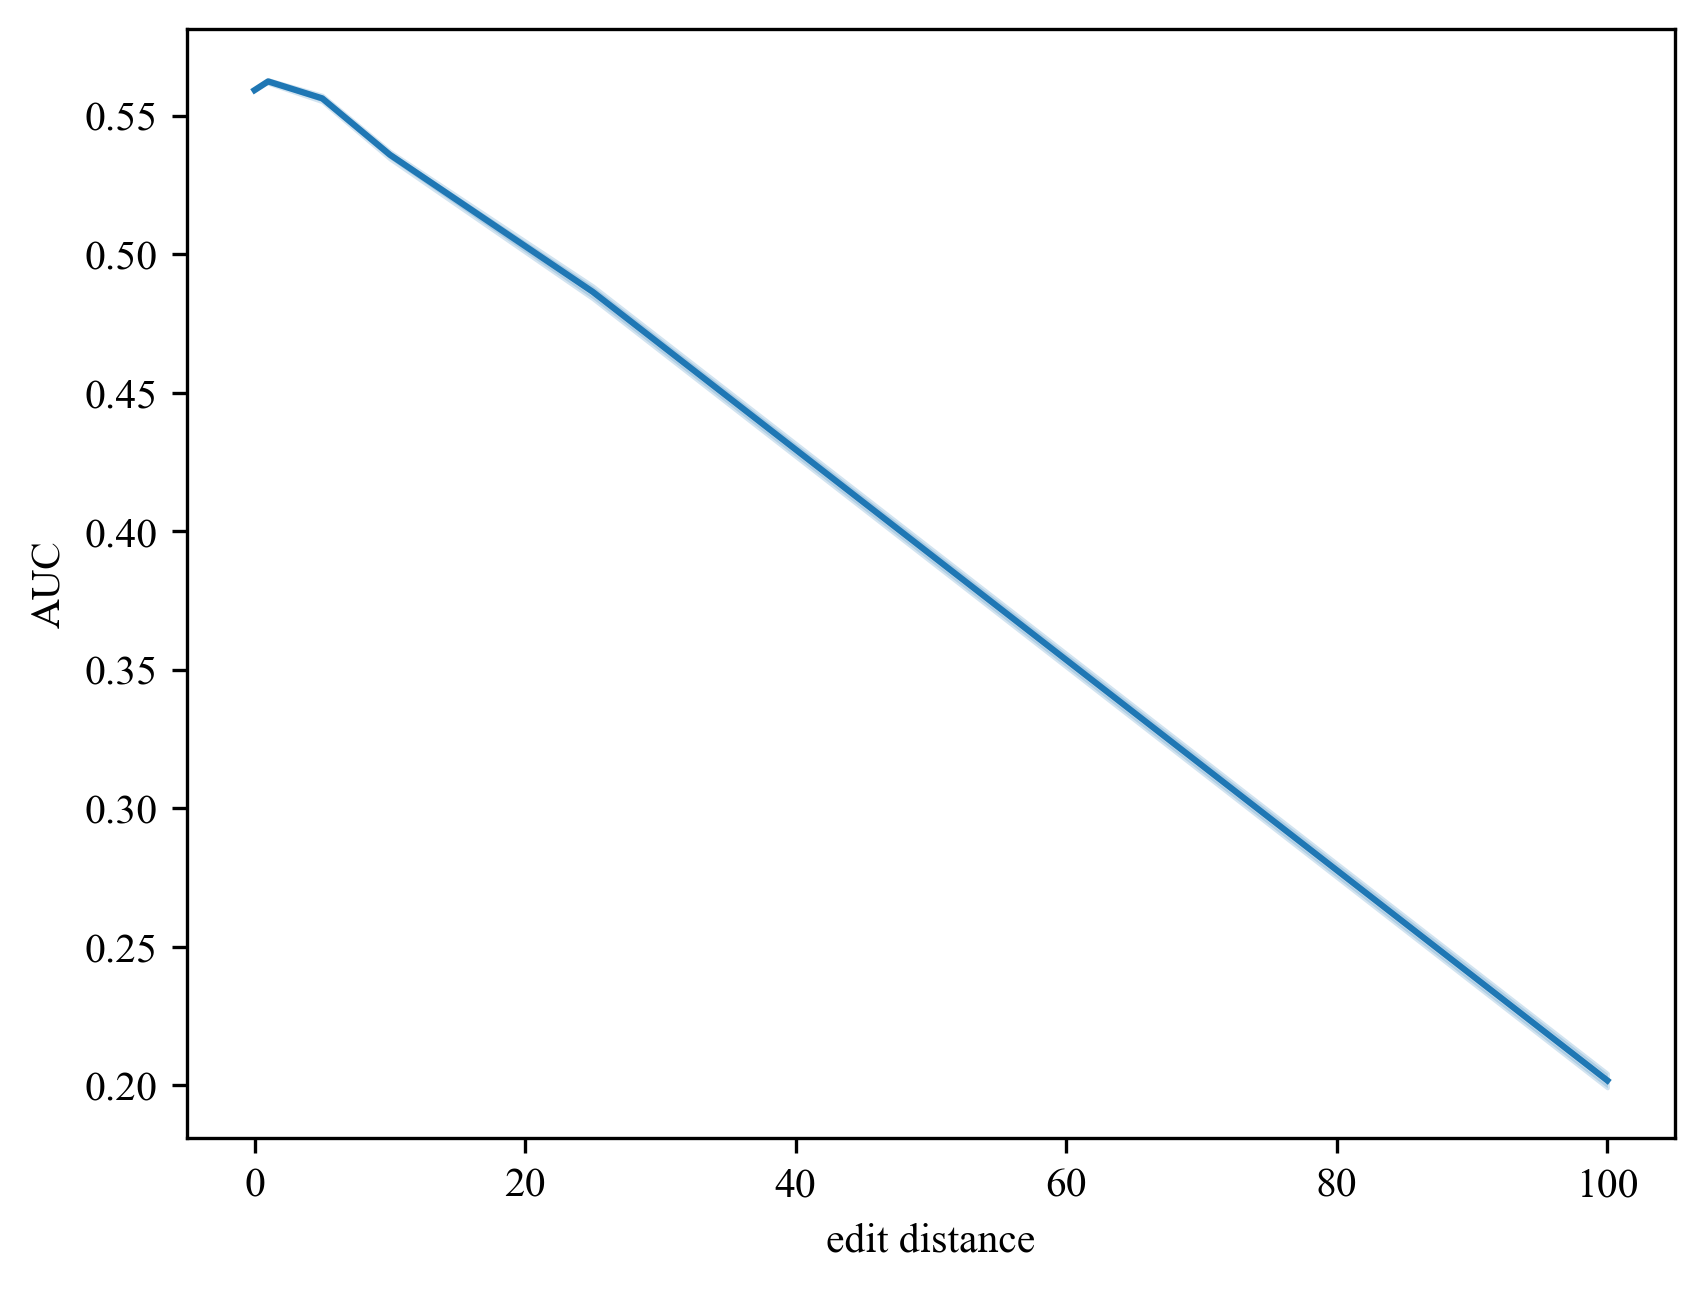

In [163]:
sns.lineplot(data=df, x='edit distance', y='AUC', markers=True, dashes=False)

In [164]:
df.groupby('edit distance').mean()

,AUC
edit distance,
0,0.559217
1,0.562364
5,0.556251
10,0.535912
25,0.486412
100,0.201805


### Consider edited-members as non-members

In [165]:
columns = ['edit distance', 'AUC']
raw_data = []
raw_data.append((0, 0.5))

for n, v in care.items():
    for score in v.values():
        # Consider "members" as members
        preds_member_ = -np.array(member_scores)
        # And edited members as "non members"
        preds_nonmember_ = -np.array(score)
        total_preds = np.concatenate((preds_member_ , preds_nonmember_))

        total_labels = [1] * len(preds_member_) + [0] * len(preds_nonmember_)
        fpr, tpr, thresholds = roc_curve(total_labels, total_preds)
        roc_auc = auc(fpr, tpr)
        
        raw_data.append((int(n), roc_auc))

In [166]:
df = pd.DataFrame(raw_data, columns=columns)

<Axes: xlabel='edit distance', ylabel='AUC'>

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

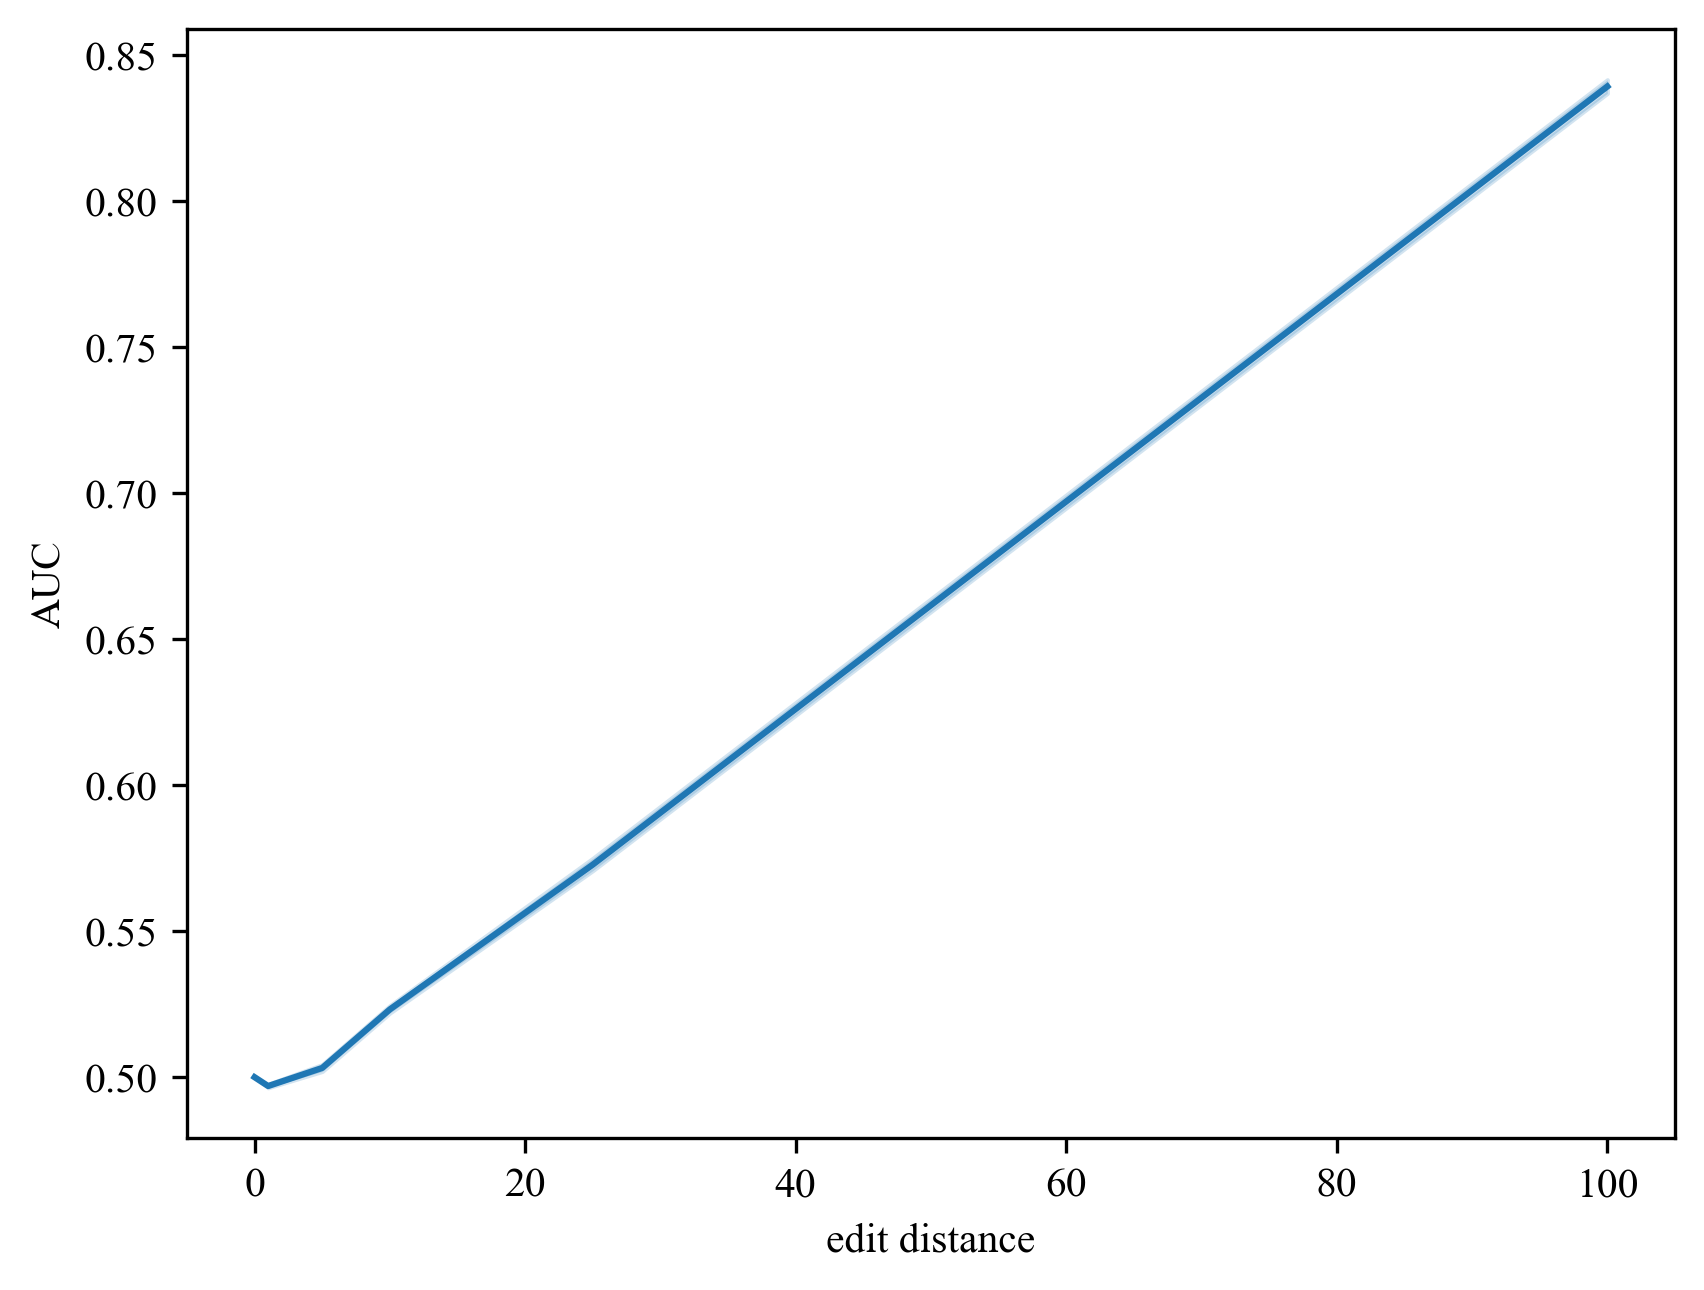

In [167]:
sns.lineplot(data=df, x='edit distance', y='AUC', markers=True, dashes=False)

In [168]:
df.groupby('edit distance').mean()

,AUC
edit distance,
0,0.500000
1,0.496969
5,0.503173
10,0.523225
25,0.572806
100,0.839357


## Score distribution (member - edited v/s member - non-member)

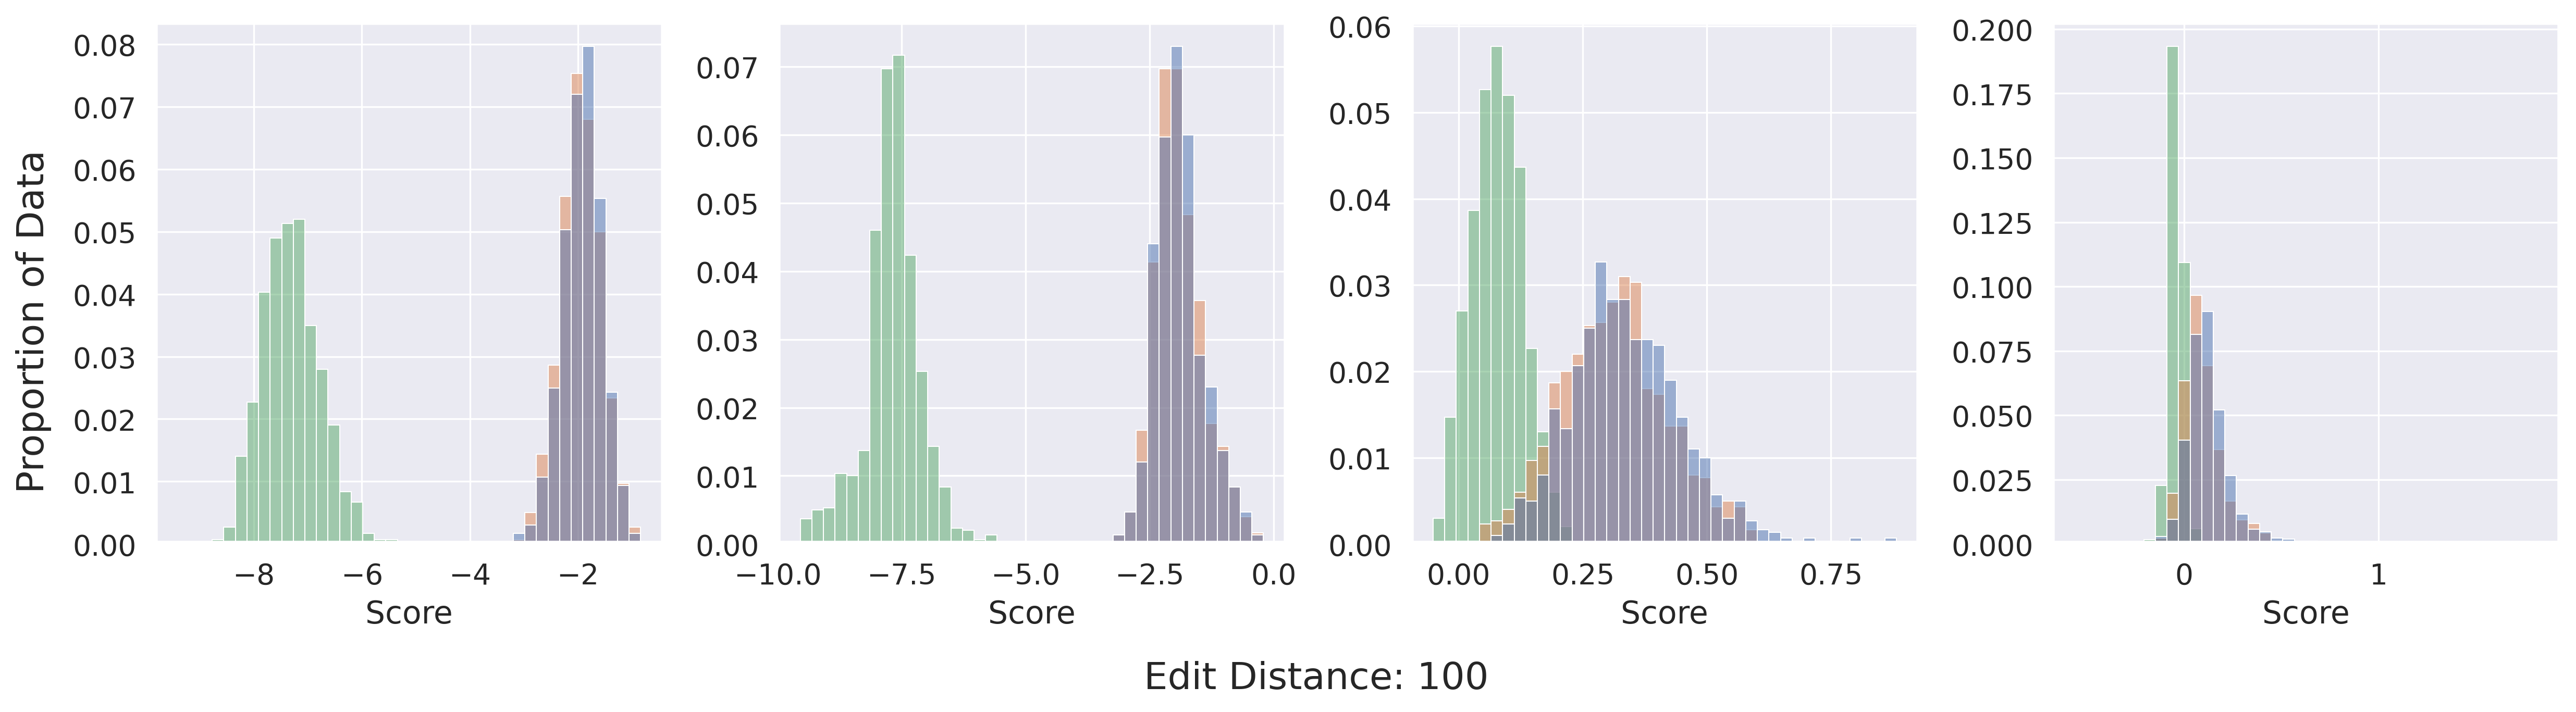

In [76]:
edit_dist = 100 # [10, 25, 100]
attacks = ['loss', 'ref-stablelm-base-alpha-3b-v2']

sns.set(style="darkgrid")
sns.set_context("paper",
                font_scale = 1.5,
                rc={
                    'lines.markersize': 5,
                    'lines.linewidth': 3,
                    'axes.linewidth': 3})

fig, axs = plt.subplots(1,
                        len(sources) * len(attacks),
                        figsize=(16, 4),
                        gridspec_kw={'wspace':0.05,'hspace':0.05},
                        layout='constrained')

for j, attack_focus in enumerate(attacks):
    for i, source in enumerate(sources):
        preds_member_, preds_nonmember_, _ = get_source_data(source, attack_focus)
        care = get_edited_member_scores(source, attack_focus)
        curr_axs = axs[j * len(attacks) + i]
        df = []
        for x in preds_member_:
            df.append({'Score': x, 'Source': 'Member'})
        for x in preds_nonmember_:
            df.append({'Score': x, 'Source': 'Non-Member'})

        all_trials = - np.array(list(care[f'{edit_dist}'].values())).mean(0)
        for x in all_trials:
            df.append({'Score': x, 'Source': f"Modified Member"})

        ds = pd.DataFrame(df)
        suffix = 'Tokens' if edit_dist > 1 else 'Token'
        sns.histplot(ds, x='Score', hue='Source',
                     stat='probability',
                     bins=40,
                     # palette=sns.color_palette('bright', 3)
                     ax=curr_axs,)
        curr_axs.legend([],[], frameon=False)
    
        curr_axs.set_ylabel(None)
        if edit_dist == 10:
            curr_axs.set_title(f"{SOURCE_NAME_MAP[source]} ({ATTACK_NAME_MAP[attack_focus]})")


legend_lines, legend_names = [], []
for k, v in COLOR_MAP.items():
    legend_lines.append(Line2D([0], [0], color=v, lw=4))
    legend_names.append(k)


x_ax = fig.supxlabel(f'Edit Distance: {edit_dist}', y=-.1) #'% Overlap'
y_ax = fig.supylabel('Proportion of Data', x=-.02)

# Legend plot
if edit_dist == 10:
    plt.figlegend(legend_lines, legend_names,
                  loc='upper center', bbox_to_anchor=(0.5, 1.1),
                  borderaxespad=0, ncol=5, fontsize=14,
                  facecolor='white', frameon=False)

plt.savefig(f"./edit_distance_figs/edit_distance_{edit_dist}.pdf", bbox_inches="tight")

## Considering edited members as non-members, what is FPR?

In [185]:
edit_dist = 25
fpr_rate = 0.1
attacks = ['loss', 'ref-stablelm-base-alpha-3b-v2']
atk = attacks[1]
# FPR 0 for LOSS attack

for i, source in enumerate(sources):
    preds_member_, preds_nonmember_, threshold = get_source_data(source, atk, fpr_rate)
    care = get_edited_member_scores(source, atk)
    
    fp = np.sum(preds_nonmember_ >= threshold)
    tn = np.sum(preds_nonmember_ < threshold)
    # print(fp/(fp+tn))

    # Compute FPR for this threshold
    fpr_computed = 0 
    num_trials = 0
    for v in care[f'{edit_dist}'].values():
        fpr_computed = np.mean(-np.array(v) >= threshold)
        num_trials += 1
    fpr_computed /= num_trials
    print(f'{source}:', '%.3f'% fpr_computed)

arxiv: 0.002
wikipedia_(en): 0.001


# Repeat analysis for semantic (NE generated) neighbors

In [ ]:
with open(f"./edit_distance_results_{source}.json", 'r') as f:
    ne_data = json.load(f)

ne_data = ne_data['loss']['0.3']
ne_care = - np.array(list(ne_data.values())).mean(0)
print(ne_care.shape)
# print(ne_data['min_k']['0.3']['0'])

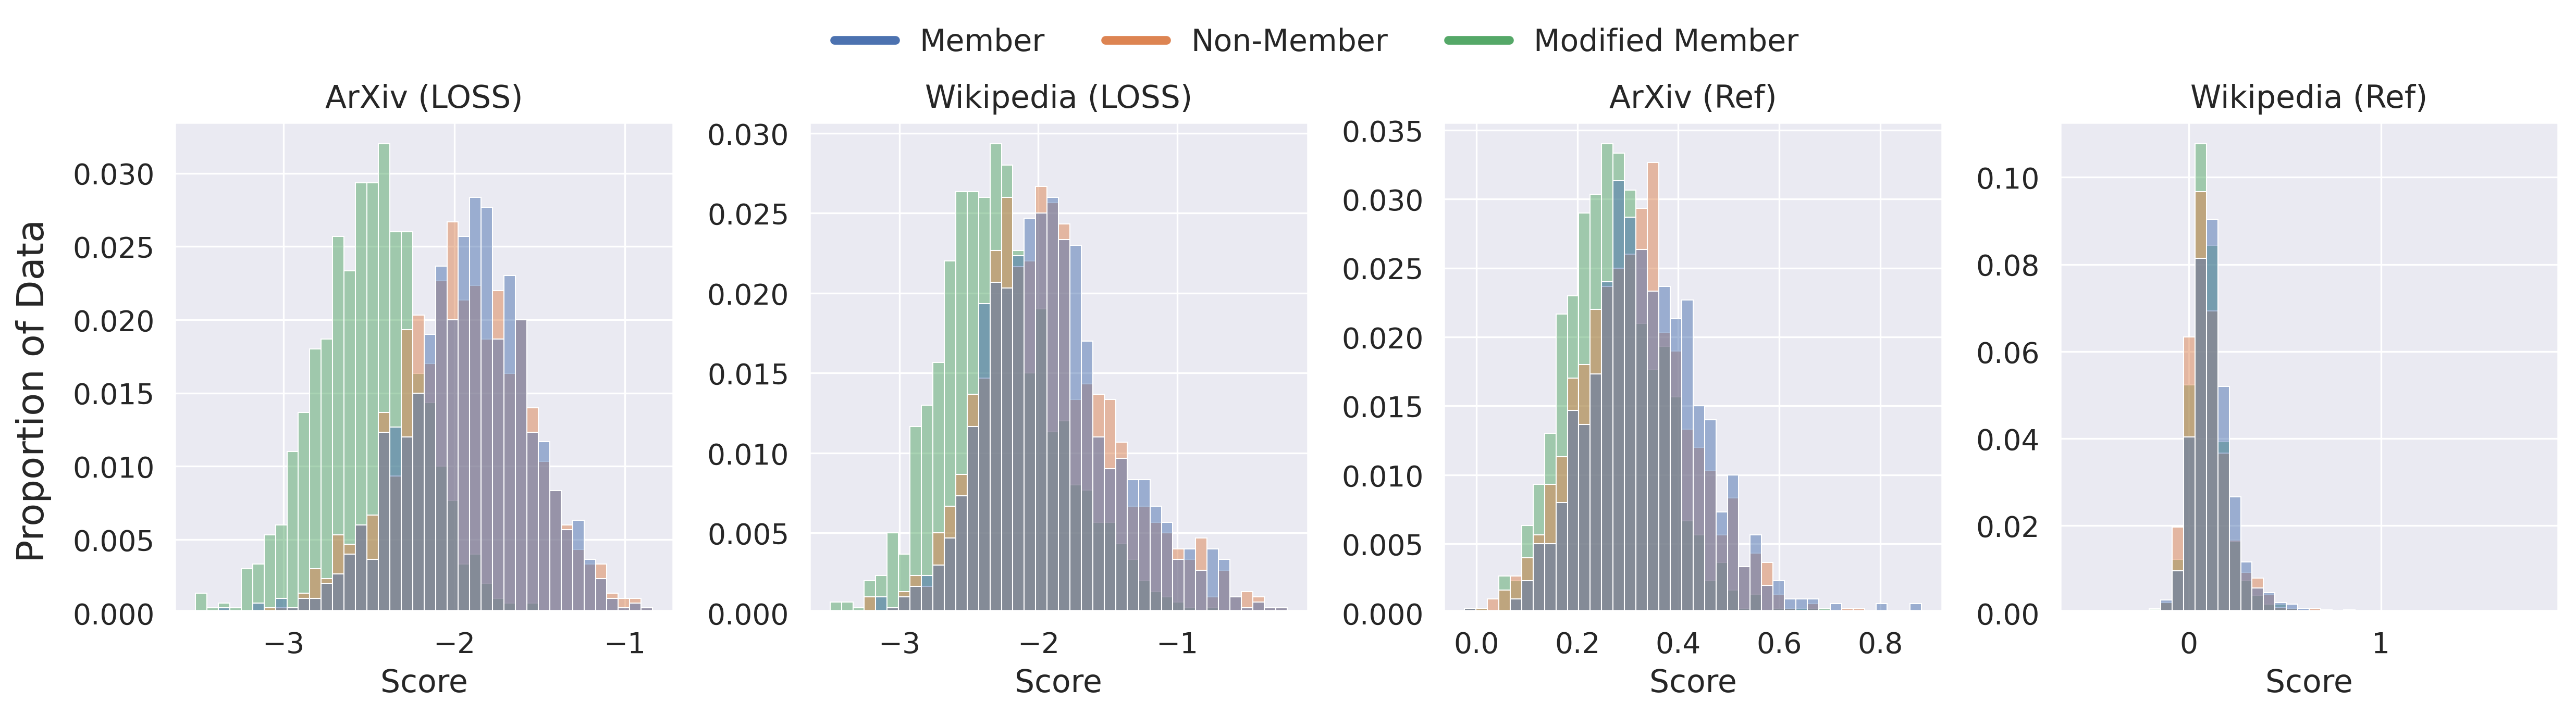

In [148]:
attacks = ['loss', 'ref-stablelm-base-alpha-3b-v2']

sns.set(style="darkgrid")
sns.set_context("paper",
                font_scale = 1.5,
                rc={
                    'lines.markersize': 5,
                    'lines.linewidth': 3,
                    'axes.linewidth': 3})

fig, axs = plt.subplots(1,
                        len(sources) * len(attacks),
                        figsize=(16, 4),
                        gridspec_kw={'wspace':0.05,'hspace':0.05},
                        layout='constrained')

for j, attack_focus in enumerate(attacks):
    for i, source in enumerate(sources):
        preds_member_, preds_nonmember_, _ = get_source_data(source, attack_focus)
        care = get_edited_member_scores(source, attack_focus)
        curr_axs = axs[j * len(attacks) + i]
        df = []
        for x in preds_member_:
            df.append({'Score': x, 'Source': 'Member'})
        for x in preds_nonmember_:
            df.append({'Score': x, 'Source': 'Non-Member'})
        
        with open(f"./edit_distance_results_{source}.json", 'r') as f:
            ne_data = json.load(f)
            ne_data = ne_data[attack_focus]['0.3']
            all_trials = - np.array(list(ne_data.values())).mean(0)

        for x in all_trials:
            df.append({'Score': x, 'Source': f"Modified Member"})

        ds = pd.DataFrame(df)
        suffix = 'Tokens' if edit_dist > 1 else 'Token'
        sns.histplot(ds, x='Score', hue='Source',
                     stat='probability',
                     bins=40,
                     # palette=sns.color_palette('bright', 3)
                     ax=curr_axs,)
        curr_axs.legend([],[], frameon=False)
    
        curr_axs.set_ylabel(None)
        curr_axs.set_title(f"{SOURCE_NAME_MAP[source]} ({ATTACK_NAME_MAP[attack_focus]})")


legend_lines, legend_names = [], []
for k, v in COLOR_MAP.items():
    legend_lines.append(Line2D([0], [0], color=v, lw=4))
    legend_names.append(k)


y_ax = fig.supylabel('Proportion of Data', x=-.02)

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.5, 1.1),
              borderaxespad=0, ncol=5, fontsize=14,
              facecolor='white', frameon=False)

plt.savefig(f"./edit_distance_figs/edit_distance_semantic.pdf", bbox_inches="tight")

In [198]:
fpr_rate = 0.1
attacks = ['loss', 'ref-stablelm-base-alpha-3b-v2']
atk = attacks[0]
# FPR 0 for LOSS attack

for i, source in enumerate(sources):
    preds_member_, preds_nonmember_, threshold = get_source_data(source, atk, fpr_rate)
    
    with open(f"./edit_distance_results_{source}.json", 'r') as f:
        ne_data = json.load(f)
        ne_data = ne_data[atk]['0.3']
        care = - np.array(list(ne_data.values()))

    # Compute FPR for this threshold
    fpr_computed = 0
    for c in care:
        fpr_computed += np.mean(c >= threshold)
    fpr_computed /= len(care)
    print(f'{source}:', '%.3f' % fpr_computed)

arxiv: 0.025
wikipedia_(en): 0.023


# Repeat analysis for Semantic Paraphrases

In [6]:
domain = "arxiv"
path = f"/mmfs1/gscratch/h2lab/micdun/mimir/edit_distance_members/scores/gpt4/gpt_paraphrase_results_{domain}.json"
with open(path, 'r') as f:
    gpt_paraphrase_data = json.load(f)

gpt_paraphrase_data = gpt_paraphrase_data['loss']['gpt']
gpt_paraphrase_care = - np.array(list(gpt_paraphrase_data.values())).mean(0)
print(gpt_paraphrase_care.shape)

(1000,)


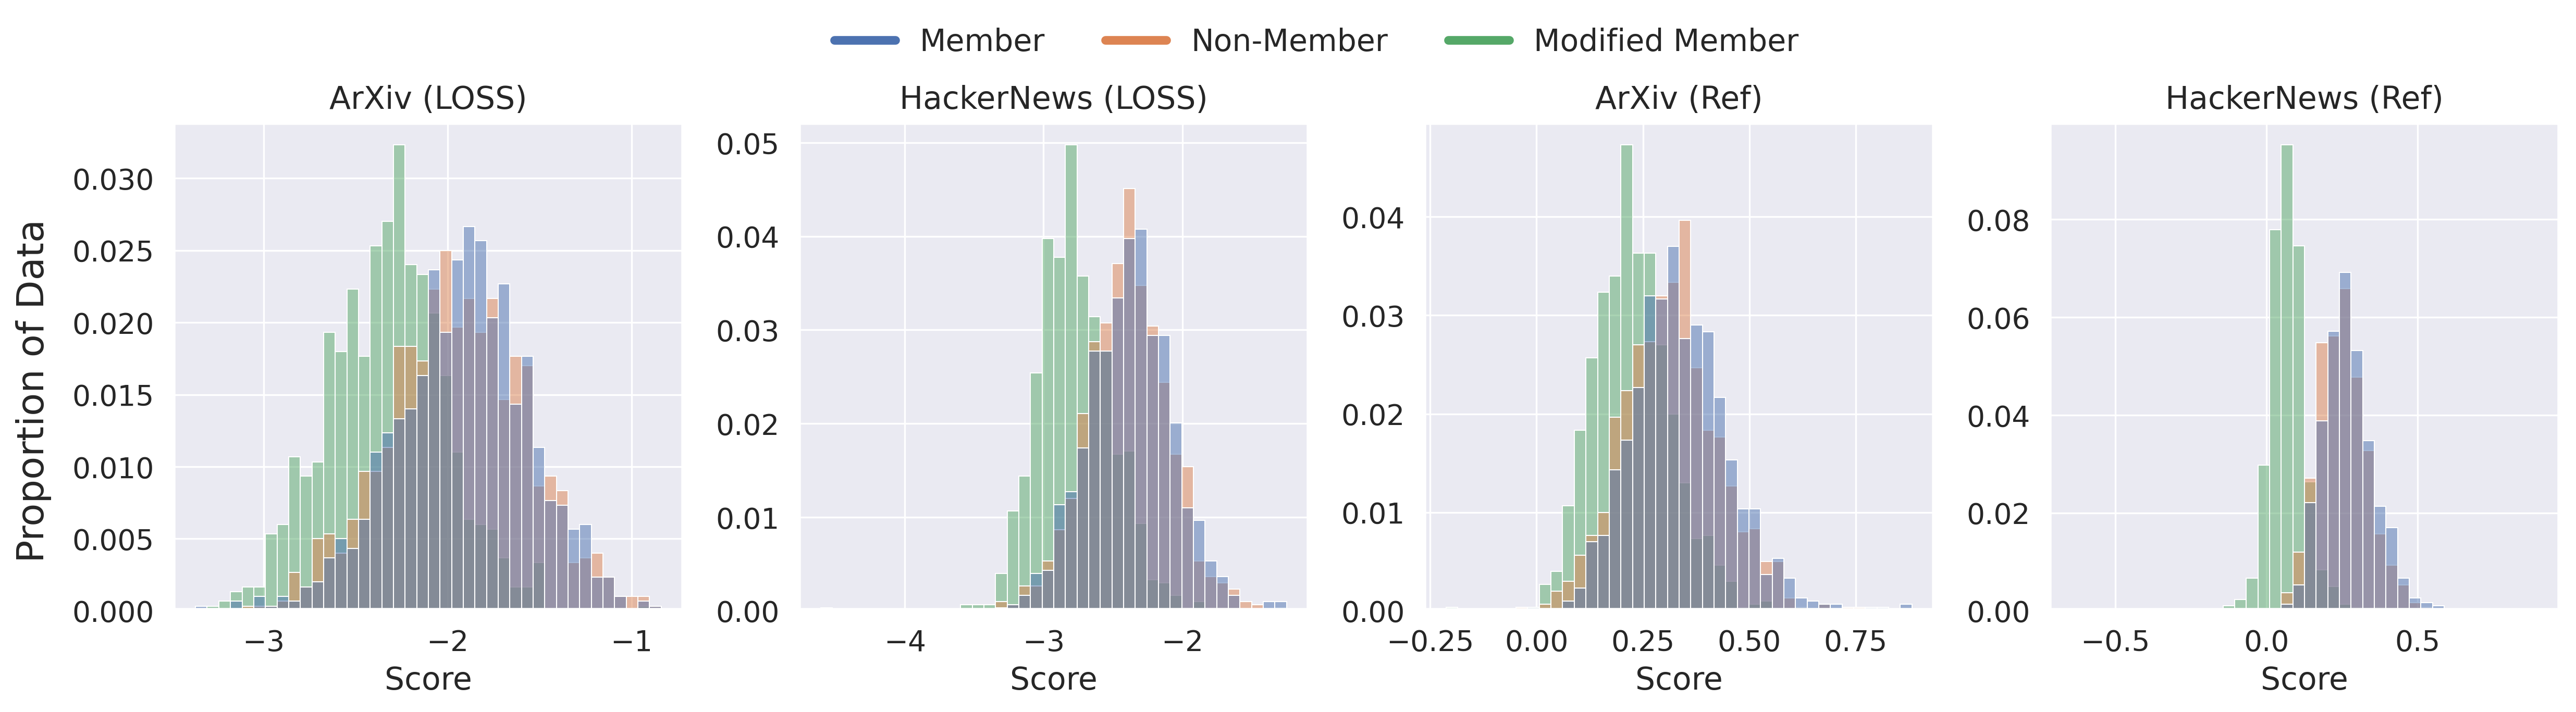

In [12]:
attacks = ['loss', 'ref-stablelm-base-alpha-3b-v2']

sns.set(style="darkgrid")
sns.set_context("paper",
                font_scale = 1.5,
                rc={
                    'lines.markersize': 5,
                    'lines.linewidth': 3,
                    'axes.linewidth': 3})

fig, axs = plt.subplots(1,
                        len(sources) * len(attacks),
                        figsize=(16, 4),
                        gridspec_kw={'wspace':0.05,'hspace':0.05},
                        layout='constrained')

for j, attack_focus in enumerate(attacks):
    for i, source in enumerate(sources):
        preds_member_, preds_nonmember_, _ = get_source_data(source, attack_focus)
        curr_axs = axs[j * len(attacks) + i]
        df = []
        for x in preds_member_:
            df.append({'Score': x, 'Source': 'Member'})
        for x in preds_nonmember_:
            df.append({'Score': x, 'Source': 'Non-Member'})
        
        path = f"/mmfs1/gscratch/h2lab/micdun/mimir/edit_distance_members/scores/gpt4/gpt_paraphrase_results_{source}.json"
        with open(path, 'r') as f:
            gpt_data = json.load(f)
            gpt_data = gpt_data[attack_focus]['gpt']
            all_trials = - np.array(list(gpt_data.values())).mean(0)

        for x in all_trials:
            df.append({'Score': x, 'Source': f"Modified Member"})

        ds = pd.DataFrame(df)
        sns.histplot(ds, x='Score', hue='Source',
                     stat='probability',
                     bins=40,
                     # palette=sns.color_palette('bright', 3)
                     ax=curr_axs,)
        curr_axs.legend([],[], frameon=False)
    
        curr_axs.set_ylabel(None)
        curr_axs.set_title(f"{SOURCE_NAME_MAP[source]} ({ATTACK_NAME_MAP[attack_focus]})")


legend_lines, legend_names = [], []
for k, v in COLOR_MAP.items():
    legend_lines.append(Line2D([0], [0], color=v, lw=4))
    legend_names.append(k)


y_ax = fig.supylabel('Proportion of Data', x=-.02)

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.5, 1.1),
              borderaxespad=0, ncol=5, fontsize=14,
              facecolor='white', frameon=False)
out_dir = "edit_distance_figs"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
plt.savefig(f"./{out_dir}/gpt_paraphrase.pdf", bbox_inches="tight")

In [18]:
fpr_rate = 0.05
attacks = ['loss', 'ref-stablelm-base-alpha-3b-v2']
# atk = attacks[0]
# FPR 0 for LOSS attack

for i, source in enumerate(sources):
    for atk in attacks:
        preds_member_, preds_nonmember_, threshold = get_source_data(source, atk, fpr_rate)

#         with open(f"./edit_distance_results_{source}.json", 'r') as f:
#             ne_data = json.load(f)
#             ne_data = ne_data[atk]['0.3']
#             care = - np.array(list(ne_data.values()))
            
        path = f"/mmfs1/gscratch/h2lab/micdun/mimir/edit_distance_members/scores/gpt4/gpt_paraphrase_results_{source}.json"
        with open(path, 'r') as f:
            gpt_data = json.load(f)
            gpt_data = gpt_data[atk]['gpt']
            care = - np.array(list(gpt_data.values()))

        # Compute FPR for this threshold
        fpr_computed = 0
        for c in care:
            fpr_computed += np.mean(c >= threshold)
        fpr_computed /= len(care)
        print(f'{source}:', '%.3f' % fpr_computed)

arxiv: 0.002
arxiv: 0.007
hackernews: 0.011
hackernews: 0.001
